lstm2

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: normalize+ denormalize

결과요약: seed 7: rmse 96.04 (마지막 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(77)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

In [5]:
sales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 282,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 230,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [6]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [7]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature + 가공

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

### X

계절

In [8]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

주중/주말(0,1)

In [9]:
day_of_week01s=[0,0,0,0,0,1,1]
day_of_week01= lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d" ).weekday())]

In [10]:
txs['season']=txs['date'].map(season)
txs['day_of_week01']=txs['date'].map(day_of_week01)
txs

,date,sales,year,month,week_number,day_of_week,season,day_of_week01
0,2016-01-01,34,2016,1,53,4,0,0
1,2016-01-02,41,2016,1,53,5,0,1
2,2016-01-03,54,2016,1,53,6,0,1
3,2016-01-04,41,2016,1,01,0,0,0
4,2016-01-05,35,2016,1,01,1,0,0
5,2016-01-06,44,2016,1,01,2,0,0
6,2016-01-07,50,2016,1,01,3,0,0
7,2016-01-08,42,2016,1,01,4,0,0
8,2016-01-09,42,2016,1,01,5,0,1
9,2016-01-10,66,2016,1,01,6,0,1


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음(아무런 가공되지 않은 원본 sales)

In [11]:
originalSales=list(txs['sales'])
sales=list(txs['sales'])

In [12]:
282 in originalSales

True

가공을 하는 순서도 중요한데, 이상점 제거-> log or sqrt -> normalization이다. 

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [13]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales

#### log(y)

In [14]:
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)

#### sqrt(y)

In [15]:
def sqrtSales(sales):
    return np.sqrt(sales)

In [16]:
# sales=noOutlierSales(sales)

In [17]:
282 in sales

True

In [18]:
282 in originalSales

True

### 1.3.2 x의 추가 가공

## 1.4 합친 후 (필요 시 normalize하여) 최종 data 생성: XY

계절(0~3) + 요일(0~6) + 주수(1~53) -> 판매량

In [19]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

계절(0~3) + 요일(0,1) + 주수(1~53) -> 판매량

In [20]:
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]

In [21]:
xy=np.array(tempxy).transpose().astype(np.float)
originalXY=np.array(tempxy).transpose().astype(np.float)

In [22]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

#### Normalization

In [23]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [24]:
xy=minMaxNormalizer(xy)

In [25]:
xy

array([[ 0.        ,  0.00701754,  0.09298246,  0.05964912],
       [ 0.        ,  0.00877193,  0.09298246,  0.07192982],
       [ 0.        ,  0.01052632,  0.09298246,  0.09473684],
       ..., 
       [ 0.        ,  0.01052632,  0.00701754,  0.        ],
       [ 0.        ,  0.        ,  0.00877193,  0.00877193],
       [ 0.        ,  0.00175439,  0.00877193,  0.05438596]])

In [26]:
# xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [27]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [28]:
#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [29]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[ 0.          0.00701754  0.09298246  0.05964912]
 [ 0.          0.00877193  0.09298246  0.07192982]
 [ 0.          0.01052632  0.09298246  0.09473684]
 [ 0.          0.          0.00175439  0.07192982]
 [ 0.          0.00175439  0.00175439  0.06140351]] -> [ 0.07719298]
[[ 0.          0.00877193  0.09298246  0.07192982]
 [ 0.          0.01052632  0.09298246  0.09473684]
 [ 0.          0.          0.00175439  0.07192982]
 [ 0.          0.00175439  0.00175439  0.06140351]
 [ 0.          0.00350877  0.00175439  0.07719298]] -> [ 0.0877193]
[[ 0.          0.01052632  0.09298246  0.09473684]
 [ 0.          0.          0.00175439  0.07192982]
 [ 0.          0.00175439  0.00175439  0.06140351]
 [ 0.          0.00350877  0.00175439  0.07719298]
 [ 0.          0.00526316  0.00175439  0.0877193 ]] -> [ 0.07368421]
[[ 0.          0.          0.00175439  0.07192982]
 [ 0.          0.00175439  0.00175439  0.06140351]
 [ 0.          0.00350877  0.00175439  0.07719298]
 [ 0.          0.00526316  0.

## 2.4 train/test split

In [30]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [31]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [32]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

In [33]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.relu)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [34]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output과 fully connected layer를  이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [35]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [36]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [37]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [38]:
train = optimizer.minimize(loss)

In [39]:
xy

array([[ 0.        ,  0.00701754,  0.09298246,  0.05964912],
       [ 0.        ,  0.00877193,  0.09298246,  0.07192982],
       [ 0.        ,  0.01052632,  0.09298246,  0.09473684],
       ..., 
       [ 0.        ,  0.01052632,  0.00701754,  0.        ],
       [ 0.        ,  0.        ,  0.00877193,  0.00877193],
       [ 0.        ,  0.00175439,  0.00877193,  0.05438596]])

In [40]:
originalSales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 282,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 230,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22

# 3. Model 평가 with RMSE

In [41]:
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

In [42]:
121 in denormalizedTestY

True

In [43]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [44]:
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

## 2.5 Train and Test

[step: 0] loss: 3.379481077194214
[step: 1] loss: 2.5305538177490234
[step: 2] loss: 1.9673771858215332
[step: 3] loss: 1.5898104906082153
[step: 4] loss: 1.4283735752105713
[step: 5] loss: 1.482645869255066
[step: 6] loss: 1.6231765747070312
[step: 7] loss: 1.7007535696029663
[step: 8] loss: 1.6870778799057007
[step: 9] loss: 1.617092490196228
[step: 10] loss: 1.5330941677093506
[step: 11] loss: 1.4646004438400269
[step: 12] loss: 1.424869179725647
[step: 13] loss: 1.4134907722473145
[step: 14] loss: 1.4219502210617065
[step: 15] loss: 1.4388898611068726
[step: 16] loss: 1.4545658826828003
[step: 17] loss: 1.4632723331451416
[step: 18] loss: 1.4634747505187988
[step: 19] loss: 1.4559378623962402
[step: 20] loss: 1.4428131580352783
[step: 21] loss: 1.4270042181015015
[step: 22] loss: 1.4114817380905151
[step: 23] loss: 1.3987464904785156
[step: 24] loss: 1.3901621103286743
[step: 25] loss: 1.386467695236206
[step: 26] loss: 1.3874156475067139
[step: 27] loss: 1.391477108001709
[step: 2

[step: 267] loss: 1.311741590499878
[step: 268] loss: 1.3113539218902588
[step: 269] loss: 1.3109663724899292
[step: 270] loss: 1.3105907440185547
[step: 271] loss: 1.3101749420166016
[step: 272] loss: 1.3098517656326294
[step: 273] loss: 1.3094565868377686
[step: 274] loss: 1.3090389966964722
[step: 275] loss: 1.3087049722671509
[step: 276] loss: 1.3082125186920166
[step: 277] loss: 1.3078010082244873
[step: 278] loss: 1.3074144124984741
[step: 279] loss: 1.3070042133331299
[step: 280] loss: 1.3065998554229736
[step: 281] loss: 1.3062020540237427
[step: 282] loss: 1.3057751655578613
[step: 283] loss: 1.3054577112197876
[step: 284] loss: 1.3050599098205566
[step: 285] loss: 1.3045614957809448
[step: 286] loss: 1.3044002056121826
[step: 287] loss: 1.3039605617523193
[step: 288] loss: 1.3034014701843262
[step: 289] loss: 1.303096890449524
[step: 290] loss: 1.3026504516601562
[step: 291] loss: 1.302298665046692
[step: 292] loss: 1.3019587993621826
[step: 293] loss: 1.3015602827072144
[ste

[step: 527] loss: 1.176204800605774
[step: 528] loss: 1.1713907718658447
[step: 529] loss: 1.1690939664840698
[step: 530] loss: 1.168313980102539
[step: 531] loss: 1.1695783138275146
[step: 532] loss: 1.1683982610702515
[step: 533] loss: 1.1735761165618896
[step: 534] loss: 1.1689567565917969
[step: 535] loss: 1.1666172742843628
[step: 536] loss: 1.164662480354309
[step: 537] loss: 1.1663570404052734
[step: 538] loss: 1.170433521270752
[step: 539] loss: 1.1690587997436523
[step: 540] loss: 1.1704527139663696
[step: 541] loss: 1.1652276515960693
[step: 542] loss: 1.161989688873291
[step: 543] loss: 1.164268136024475
[step: 544] loss: 1.1768436431884766
[step: 545] loss: 1.2037149667739868
[step: 546] loss: 1.1650655269622803
[step: 547] loss: 1.3395521640777588
[step: 548] loss: 1.3217978477478027
[step: 549] loss: 1.3538566827774048
[step: 550] loss: 1.3781521320343018
[step: 551] loss: 1.3873217105865479
[step: 552] loss: 1.381696105003357
[step: 553] loss: 1.3699511289596558
[step: 5

[step: 751] loss: 1.3022829294204712
[step: 752] loss: 1.3022388219833374
[step: 753] loss: 1.3021936416625977
[step: 754] loss: 1.3021574020385742
[step: 755] loss: 1.3021104335784912
[step: 756] loss: 1.3020718097686768
[step: 757] loss: 1.3020312786102295
[step: 758] loss: 1.3019874095916748
[step: 759] loss: 1.3019607067108154
[step: 760] loss: 1.3019086122512817
[step: 761] loss: 1.3018728494644165
[step: 762] loss: 1.3018324375152588
[step: 763] loss: 1.3017899990081787
[step: 764] loss: 1.3017446994781494
[step: 765] loss: 1.3017232418060303
[step: 766] loss: 1.3016630411148071
[step: 767] loss: 1.3016256093978882
[step: 768] loss: 1.30158531665802
[step: 769] loss: 1.301542043685913
[step: 770] loss: 1.3015034198760986
[step: 771] loss: 1.3014638423919678
[step: 772] loss: 1.301427960395813
[step: 773] loss: 1.3013883829116821
[step: 774] loss: 1.3013460636138916
[step: 775] loss: 1.3013006448745728
[step: 776] loss: 1.301253080368042
[step: 777] loss: 1.3012374639511108
[step:

[step: 993] loss: 1.291788935661316
[step: 994] loss: 1.2917864322662354
[step: 995] loss: 1.2917133569717407
[step: 996] loss: 1.2917759418487549
[step: 997] loss: 1.2917574644088745
[step: 998] loss: 1.2916158437728882
[step: 999] loss: 1.2914164066314697
RMSE: 20.81618309020996


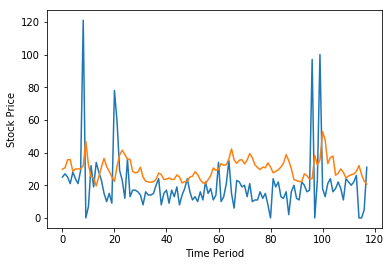

In [45]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalSales)
    rmse_val = sess.run(rmse, feed_dict={targets: denormalizedTestY_feed, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [46]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [47]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

20.816183145442604

In [48]:
121 in denormalizedTestY

True